Link of the notes
https://www.kaggle.com/code/qianweijia/ts-0-the-basics/edit

In [2]:
import pandas as pd
import numpy as np
from random import gauss
from pandas.plotting import autocorrelation_plot
import warnings
import itertools
from random import random

import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 
# import matplotlib as mpl
import seaborn as sns     

In [3]:
# general settings
class CFG:
    data_folder = '../input/tsdata-1/'
    img_dim1 = 20
    img_dim2 = 10
    
    
# adjust the parameters for displayed figures    
plt.rcParams.update({'figure.figsize': (CFG.img_dim1,CFG.img_dim2)})

<a id="section-four"></a>
# Patterns of time series

The first we can do to identify patterns in a time series is separate it into components with easily understandable characteristics:
​
\begin{equation}
X_t = T_t + S_t + C_t + I_t \quad 
\end{equation}
​
where: 
* $T_t$: the trend shows a general direction of the time series data over a long period of time. It represents a long-term progression of the series (secular variation)  
​
* $S_t$: the seasonal component with fixed and known period. It is observed when there is a distinct repeated pattern observed between regular intervals due to seasonal factors: annual, monthly or weekly. Obvious examples include daily power consumption patterns or annual sales of seasonal goods.
​
* $C_t$: (optional) cyclical component is a repetitive pattern which does not occur at fixed intervals - usually observed in an economic context like business cycles. 
​
* $I_t$: the irregular component (residuals ) consists of the fluctuations in the time series that are observed after removing trend and seasonal / cyclical variations. 


<AxesSubplot: xlabel='date'>

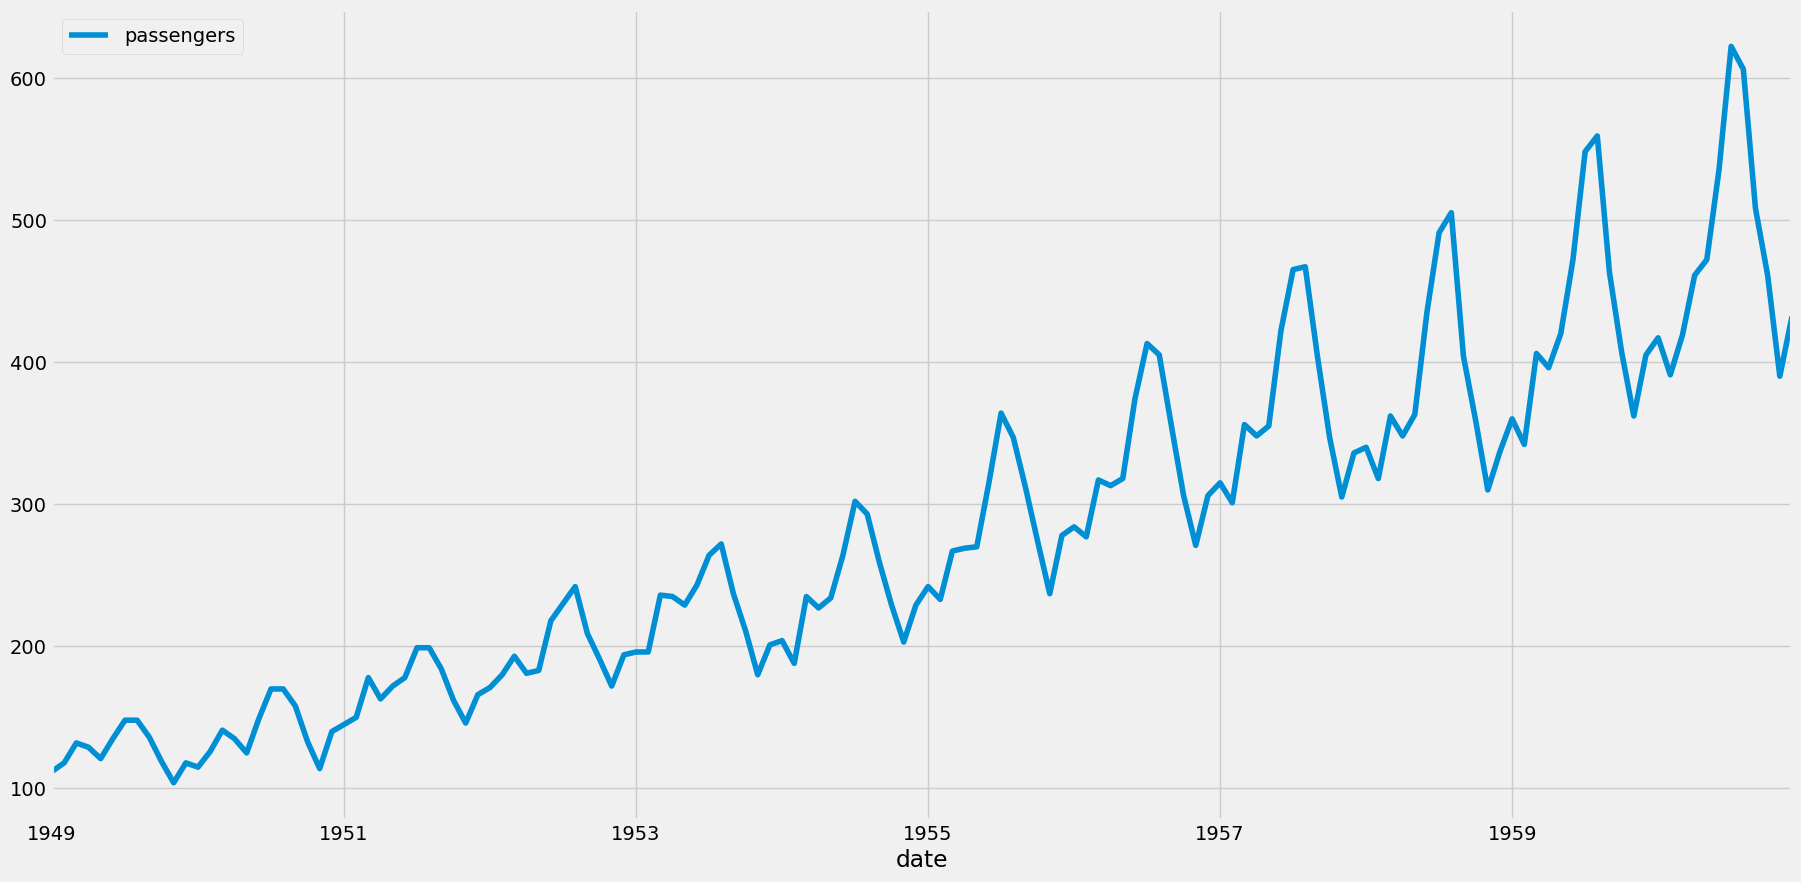

In [5]:
series = pd.read_csv( 'passengers.csv')
series['date'] = pd.to_datetime(series['date'])
series.set_index('date').plot()


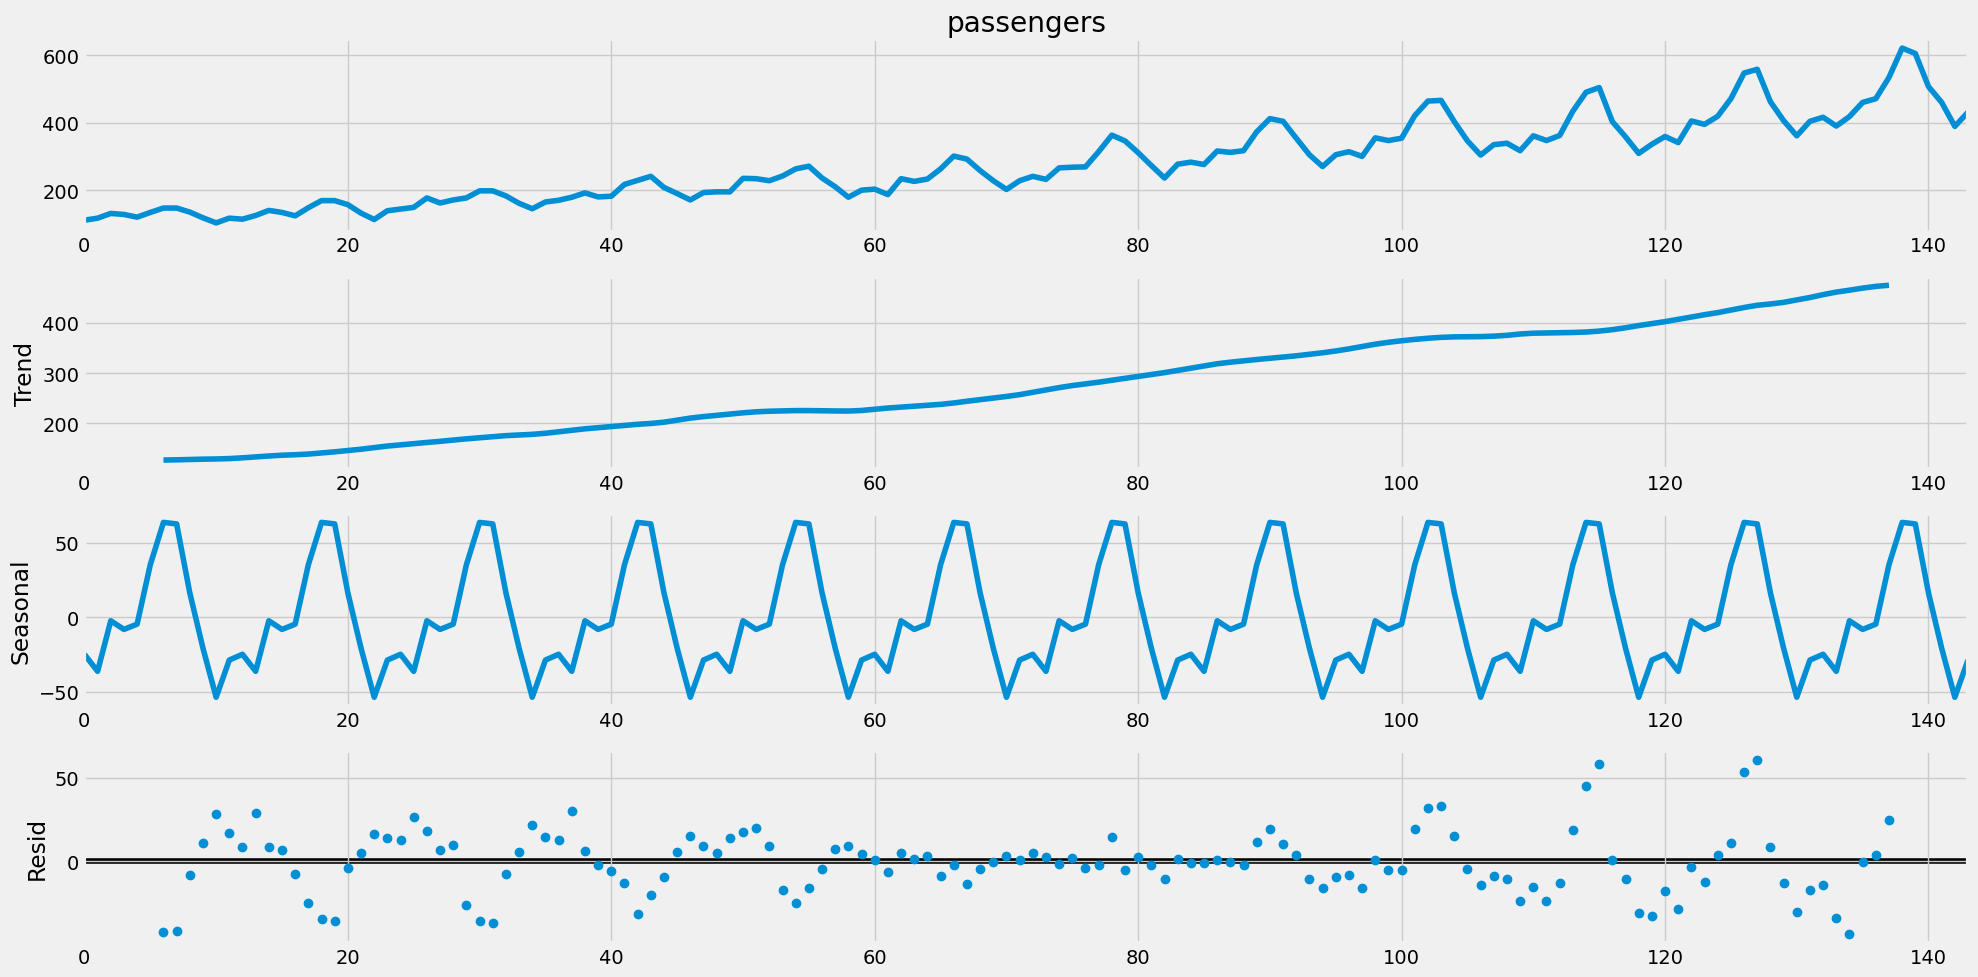

In [6]:
# decomposition
decomposition = sm.tsa.seasonal_decompose(series["passengers"],period =12) 
figure = decomposition.plot()
plt.show()

<a id="section-four"></a>
# Dependence

The only way to succesful prediction is if past values of a series carry some information about the future behavior - in other words, if the present values are dependent on the past. A fast - and therefore very popular - manner of examining this dependence are the autocorrelation and partial autocorrelation functions, which are defined below:

Mean function of time series:
\begin{equation}
\mu_t = E [X_t]
\end{equation}

Autocovariance function of a time series:
\begin{equation}
\gamma(s,t) = Cov(X_s, X_t) = E [X_s X_t] - E[X_s]E[X_t]
\end{equation}

which leads to the following definitions of ACF / PACF:

Autocorrelation:
\begin{equation}
\rho(u,t+u) = Cor(X_{u}, X_{t+u}) = \frac{Cov(X_t, X_{t+u})}{Var(X_t) Var(X_{t+u})}
\end{equation}

Partial autocorrelation:
    \begin{equation}
    \phi(u) = Cor(X_t, X_{t+u}|X_{t+1}, \ldots , X_{t+u-1})
    \end{equation}

An intuitive way to think about it is that ACF at lag $k$ measures a linear dependence between $X_t$ and $X_{t+k}$, while PACF captures the dependence between those values **correcting** for all the intermediate effects. 

<a id="section-four"></a>
# Stationarity

Since stationarity is an assumption underlying many statistical procedures used in time series analysis, **non-stationary data are often transformed to become stationary**. A trend stationary process is not strictly stationary, but can easily be transformed into a stationary process by **removing the underlying trend**, which is solely a function of time; the same holds true for a stationary process with an added cyclical component. 

If we are dealing with a process that does not adhere to those characteristics, we can either try and capture them directly or transform it in such a manner that it can be considered stationary. 


The stationarity of a series can be checked by examining the distribution of the series: **we split the series into 2 contiguous parts and compute the summary statistics like the mean, variance and the autocorrelation.** If the stats are quite different, then the series is not likely to be stationary.

<AxesSubplot: xlabel='date'>

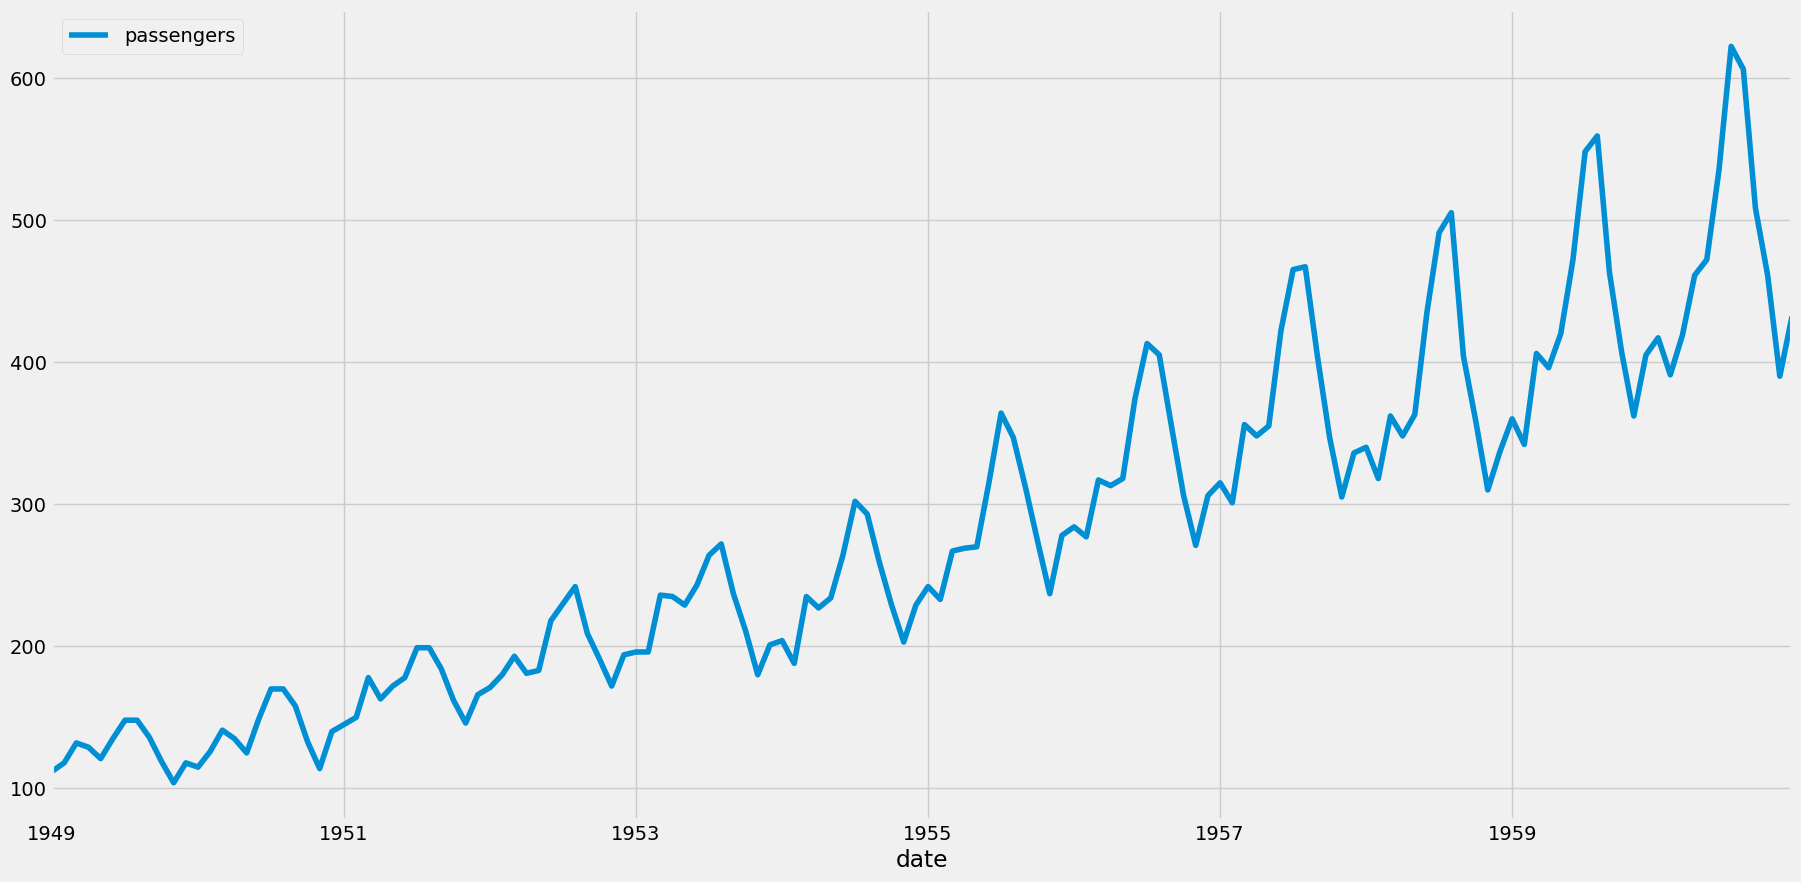

In [8]:
series = pd.read_csv( 'passengers.csv')
series['date'] = pd.to_datetime(series['date'])
series.set_index('date').plot()

<AxesSubplot: ylabel='Frequency'>

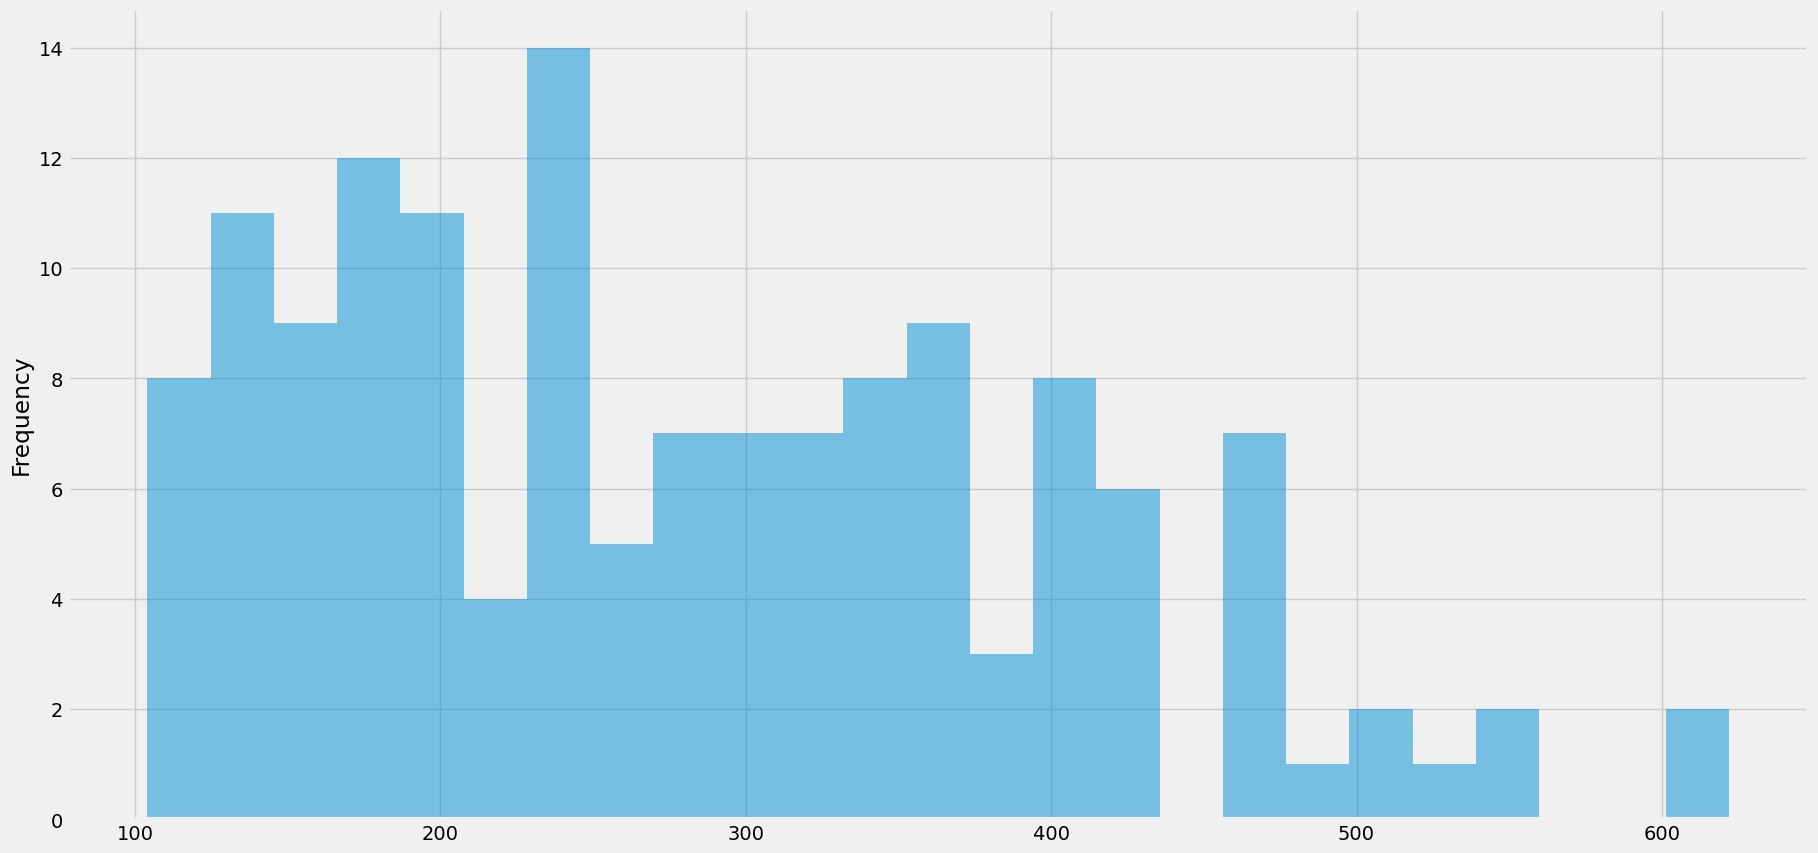

In [9]:
series = pd.read_csv( 'passengers.csv')
series['date'] = pd.to_datetime(series['date'])
# series.set_index('date').plot()

series['passengers'].plot.hist(bins=25, alpha=0.5)

In [10]:
X = series.passengers.values
split =  int(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean:')
print('chunk1: %.2f vs chunk2: %.2f' % (mean1, mean2))
print('variance:')
print('chunk1: %.2f vs chunk2: %.2f' % (var1, var2))


mean:
chunk1: 182.90 vs chunk2: 377.69
variance:
chunk1: 2244.09 vs chunk2: 7367.96


The values are clearly very different across the two data subsets, which strongly suggests non-stationarity. However, visual inspection is not what one would could a rigorous criterion - so let's define things in a formal manner.